In [44]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

In [45]:
df = pd.read_csv('ecg_autoencoder_dataset.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [46]:
X = df.drop([140], axis = 1)
y = df[140]

In [47]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)

In [49]:
input_dim = x_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)

latent = Dense(4, activation="relu")(encoded)

decoded = Dense(8, activation="relu")(latent)
decoded = Dense(16, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoen = Model(inputs = input_layer, outputs = decoded)
autoen.compile(optimizer="adam", loss="mse")

In [50]:
history = autoen.fit(x_train, x_train, epochs = 100, batch_size=256, validation_data=(x_test,x_test))

Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 1.2543 - val_loss: 1.1369
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 1.2029 - val_loss: 1.0666
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 1.1189 - val_loss: 0.9830
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 1.0434 - val_loss: 0.9272
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.9974 - val_loss: 0.8937
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9652 - val_loss: 0.8627
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9334 - val_loss: 0.8332
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9065 - val_loss: 0.8098
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 0.8852 - val_loss: 0.7928
Epoch 10/100
16/16 [==============================] - 0s 6ms/step - loss: 0.8712 - val_loss: 0.7827
Epoch 11

In [51]:
reconstructions = autoen.predict(x_train)
reconstruction_err = np.mean(np.square(reconstructions-x_train), axis = 1)

threshold = np.percentile(reconstruction_err, 95)
print(threshold)

125/125 [==============================] - 0s 2ms/step
2.3183089731725746


In [52]:
test_recon = autoen.predict(x_test)
test_errors = np.mean(np.square(test_recon-x_test), axis = 1)

pred = [1 if err > threshold else 0 for err in test_errors]

accuracy = accuracy_score(y_test, pred)
confmat = confusion_matrix(y_test, pred)
print(accuracy)
print(confmat)

32/32 [==============================] - 0s 2ms/step
0.405
[[388  27]
 [568  17]]


In [53]:
anomalies = test_errors > threshold
ansum = np.sum(anomalies)
print(ansum)

44


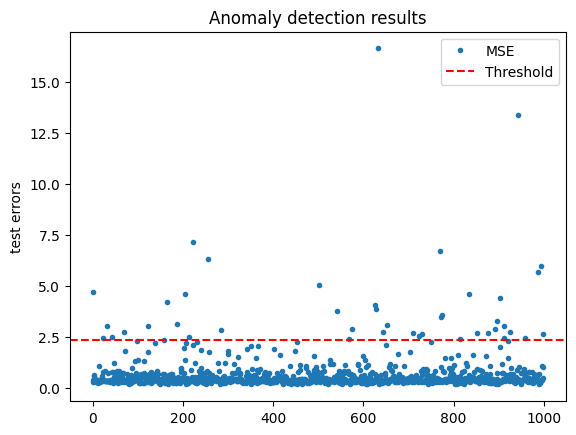

In [54]:
plt.plot(test_errors, marker='o', linestyle='', markersize=3, label='MSE')
plt.axhline(threshold, color='r', linestyle='--', markersize=4, label = 'Threshold')
plt.ylabel('test errors')
plt.title('Anomaly detection results')
plt.legend()
plt.show()

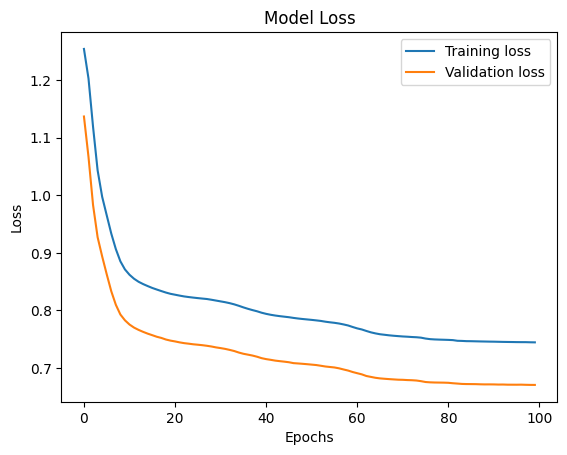

In [55]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()